In [2]:
import json, os
import cv2
import torch
from multiprocessing import Pool, Manager
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.akpd import AKPD
from aquabyte.template_matching import find_matches_and_homography
from aquabyte.biomass_estimator import NormalizeCentered2D, NormalizedStabilityTransform, ToTensor, Network
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
from aquabyte.akpd_scorer import generate_confidence_score
from keras.models import load_model
import boto3
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import time

Using TensorFlow backend.


In [3]:
# s3_access_utils = S3AccessUtils('/root/data')
# rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

# df1 = pd.read_csv('/root/data/alok/biomass_estimation/playground/biomass.csv-61-00-from-2019-09-13-to-2019-09-23.csv')
# df1.index = pd.to_datetime(df1.captured_at)

In [4]:
s3_access_utils = S3AccessUtils('/root/data')
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

query = """
    SELECT * FROM
    prod.crop_annotation cas
    INNER JOIN prod.annotation_state pas on pas.id=cas.annotation_state_id
    WHERE cas.service_id = (SELECT ID FROM prod.service where name='BATI')
    AND cas.annotation is not null
    AND cas.pen_id=61
    AND cas.group_id='staging-61'
    AND cas.captured_at between '2019-09-13' and '2019-09-21';
"""

df1 = rds_access_utils.extract_from_database(query)
aws_credentials = json.load(open(os.environ['AWS_CREDENTIALS']))
akpd = AKPD(aws_credentials)

to_tensor_transform = ToTensor()

# initialize data transforms so that we can run inference with biomass neural network
normalize_centered_2D_transform_biomass = NormalizeCentered2D()
normalized_stability_transform = NormalizedStabilityTransform()

# load neural network weights
biomass_network = torch.load('/root/data/alok/biomass_estimation/results/neural_network/2019-11-08T00:13:09/nn_epoch_798.pb')
akpd_scorer_network = load_model('/root/data/alok/biomass_estimation/playground/akpd_scorer_model_TF.h5') # make this better

In [5]:
def generate_weight_score(row_id, left_crop_url, right_crop_url, left_crop_metadata, right_crop_metadata, akpd_keypoints, cm):
    
    # run AKPD scoring network
    input_sample = {
        'keypoints': akpd_keypoints,
        'cm': row.camera_metadata,
        'stereo_pair_id': row.id,
        'single_point_inference': True
    }
    akpd_score = generate_confidence_score(input_sample, akpd_scorer_network)

    # run biomass estimation
    input_sample = {
        'keypoints': akpd_keypoints,
        'cm': row.camera_metadata,
        'stereo_pair_id': row.id,
        'single_point_inference': True
    }
    nomralized_centered_2D_kps = \
        normalize_centered_2D_transform_biomass.__call__(input_sample)

    normalized_stability_kps = normalized_stability_transform.__call__(nomralized_centered_2D_kps)
    tensorized_kps = to_tensor_transform.__call__(normalized_stability_kps)
    akpd_weight_prediction = biomass_network(tensorized_kps['kp_input']).item() * 1e4
    
    
    return akpd_score, akpd_weight_prediction


In [6]:
weight_score_dict = {}

args = []
count = 0
for idx, row in df1.iterrows():
    left_crop_url, right_crop_url = row.left_crop_url, row.right_crop_url
    left_crop_metadata, right_crop_metadata = row.left_crop_metadata, row.right_crop_metadata,
    cm = row.camera_metadata
    akpd_keypoints = row.annotation
    row_id = idx
    akpd_score, akpd_weight_prediction = generate_weight_score(row_id, left_crop_url, right_crop_url, left_crop_metadata, right_crop_metadata, akpd_keypoints, cm)
    weight_score_dict[row_id] = {
        'akpd_score': akpd_score,
        'akpd_weight_prediction': akpd_weight_prediction,
    }
    
    if count % 100 == 0:
        print(count)
    count += 1

0
100
200


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700


In [7]:
weights, akpd_scores = [], []
for idx, row in df1.iterrows():
    if idx in weight_score_dict.keys():
        weight = weight_score_dict[idx]['akpd_weight_prediction']
        weights.append(weight)
        akpd_score = weight_score_dict[idx]['akpd_score']
        akpd_scores.append(akpd_score)
    else:
        weights.append(None)
        akpd_scores.append(None)

df1['weight'] = weights
df1['akpd_score'] = akpd_scores
df1.index = pd.to_datetime(df1.captured_at)
df1['ts'] = df1.captured_at
df1 = df1.sort_values('ts')

<h1> Generate Other DF </h1>

In [8]:
s3_access_utils = S3AccessUtils('/root/data')
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

df2 = pd.read_csv('/root/data/alok/biomass_estimation/playground/61_sample.biomass_output-CORE-404.1f.csv')
df2.index = pd.to_datetime(df2.captured_at)
df2['ts'] = df2.captured_at
df2 = df2.sort_values('ts')

In [9]:
mask = df1.captured_at < '2019-09-21'
df1[mask & (df1.akpd_score > 0.9)].weight.mean()

3045.464971075857

In [10]:
mask = df2.captured_at < '2019-09-21'
df2[mask & (df2.akpd_score > 0.9)].weight.mean()

3142.164325013437

In [11]:
df1.left_crop_url.iloc[0]

'https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=staging/site-id=40/pen-id=61/date=2019-09-13/hour=00/at=2019-09-13T00:00:57.613770000Z/left_frame_crop_238_1520_2810_2171.jpg'

In [14]:
tdf1 = df1.copy(deep=True)
tdf2 = df2.copy(deep=True)
tdf1['adj_left_crop_url'] = tdf1.left_crop_url.apply(lambda x: x.replace('https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=staging/', 
                                                                         'https://s3-eu-west-1.amazonaws.com/aquabyte-crops-test/environment=production/'))
common_urls = list(set(tdf1.adj_left_crop_url).intersection(set(tdf2.left_crop_url)))
tdf1 = tdf1[tdf1.adj_left_crop_url.isin(common_urls)].copy(deep=True)
tdf2 = tdf2[tdf2.left_crop_url.isin(common_urls)].copy(deep=True)


In [15]:
mask = (tdf1.akpd_score > 0.9) & (tdf2.akpd_score > 0.9)
tdf1[mask].weight - tdf2[mask].weight

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


captured_at
2019-09-13 00:17:51.762412+00:00   -275.022686
2019-09-13 00:54:17.193277+00:00   -263.013542
2019-09-13 01:00:22.850653+00:00    -67.747533
2019-09-13 01:01:59.689289+00:00    -54.416656
2019-09-13 01:10:35.018484+00:00    -75.309873
                                       ...    
2019-09-20 21:30:46.159217+00:00    -64.511597
2019-09-20 21:34:31.971521+00:00   -127.579570
2019-09-20 21:45:22.188453+00:00    273.100138
2019-09-20 22:43:19.892081+00:00   -125.068426
2019-09-20 22:47:18.997133+00:00   -148.831308
Name: weight, Length: 3251, dtype: float64

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


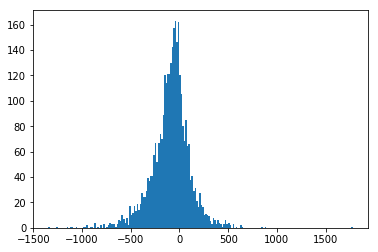

In [16]:
plt.hist(tdf1[mask].weight - tdf2[mask].weight, bins=200)
plt.show()

In [17]:
json.loads(tdf2[mask].annotation.iloc[0])

{'id': 5,
 'leftCrop': [{'xCrop': 1669,
   'yCrop': 239,
   'xFrame': 2505,
   'yFrame': 2259,
   'keypointType': 'TAIL_NOTCH'},
  {'xCrop': 1304,
   'yCrop': 210,
   'xFrame': 2140,
   'yFrame': 2230,
   'keypointType': 'ADIPOSE_FIN'},
  {'xCrop': 98,
   'yCrop': 474,
   'xFrame': 934,
   'yFrame': 2494,
   'keypointType': 'UPPER_LIP'},
  {'xCrop': 1220,
   'yCrop': 454,
   'xFrame': 2056,
   'yFrame': 2474,
   'keypointType': 'ANAL_FIN'},
  {'xCrop': 883,
   'yCrop': 542,
   'xFrame': 1719,
   'yFrame': 2562,
   'keypointType': 'PELVIC_FIN'},
  {'xCrop': 210,
   'yCrop': 484,
   'xFrame': 1046,
   'yFrame': 2504,
   'keypointType': 'EYE'},
  {'xCrop': 406,
   'yCrop': 562,
   'xFrame': 1242,
   'yFrame': 2582,
   'keypointType': 'PECTORAL_FIN'},
  {'xCrop': 715,
   'yCrop': 220,
   'xFrame': 1551,
   'yFrame': 2240,
   'keypointType': 'DORSAL_FIN'}],
 'rightCrop': [{'xCrop': 1657,
   'yCrop': 249,
   'xFrame': 2215,
   'yFrame': 2247,
   'keypointType': 'TAIL_NOTCH'},
  {'xCrop': 130

In [18]:
bp = 'PELVIC_FIN'
disps1 = []
for idx, row in tdf1[mask].iterrows():
    ann = row.annotation
    left_kps = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann['leftCrop']}
    right_kps = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann['rightCrop']}
    disp = left_kps[bp][0] - right_kps[bp][0]
    disps1.append(disp)
    
disps2 = []
for idx, row in tdf2[mask].iterrows():
    ann = json.loads(row.annotation)
    left_kps = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann['leftCrop']}
    right_kps = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann['rightCrop']}
    disp = left_kps[bp][0] - right_kps[bp][0]
    disps2.append(disp)
    
print(np.mean(np.array(disps1) - np.array(disps2)))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


6.435558289756998


In [19]:
cm1 = df1.camera_metadata.iloc[0]

In [20]:
cm2 = {
    'focalLengthPixel': 3995.5062171346935,
    'pixelCountWidth': 4096,
    'pixelCountHeight': 3000,
    'imageSensorWidth': 0.01412,
    'imageSensorHeight': 0.01035,
    'baseline': 0.10152658650444619,
    'focalLength': 3995.5062171346935 * 3.45e-6
}

In [21]:
bp1, bp2 = 'UPPER_LIP', 'EYE'
tdf1.loc[mask, 'world_keypoints'] = tdf1[mask].annotation.apply(lambda x: pixel2world(x['leftCrop'], 
                                                  x['rightCrop'], cm1))

tdf1.loc[mask, 'length'] = tdf1[mask].world_keypoints.apply(lambda x: euclidean_distance(x[bp1], x[bp2]))

tdf2.loc[mask, 'world_keypoints'] = tdf2[mask].annotation.apply(lambda x: pixel2world(json.loads(x)['leftCrop'], 
                                                  json.loads(x)['rightCrop'], cm1))
tdf2.loc[mask, 'length'] = tdf2[mask].world_keypoints.apply(lambda x: euclidean_distance(x[bp1], x[bp2]))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [22]:
(tdf1[mask].length - tdf2[mask].length).median()

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


-0.000969515783826827

In [23]:
tdf1.length.mean()

0.09522628919493453

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


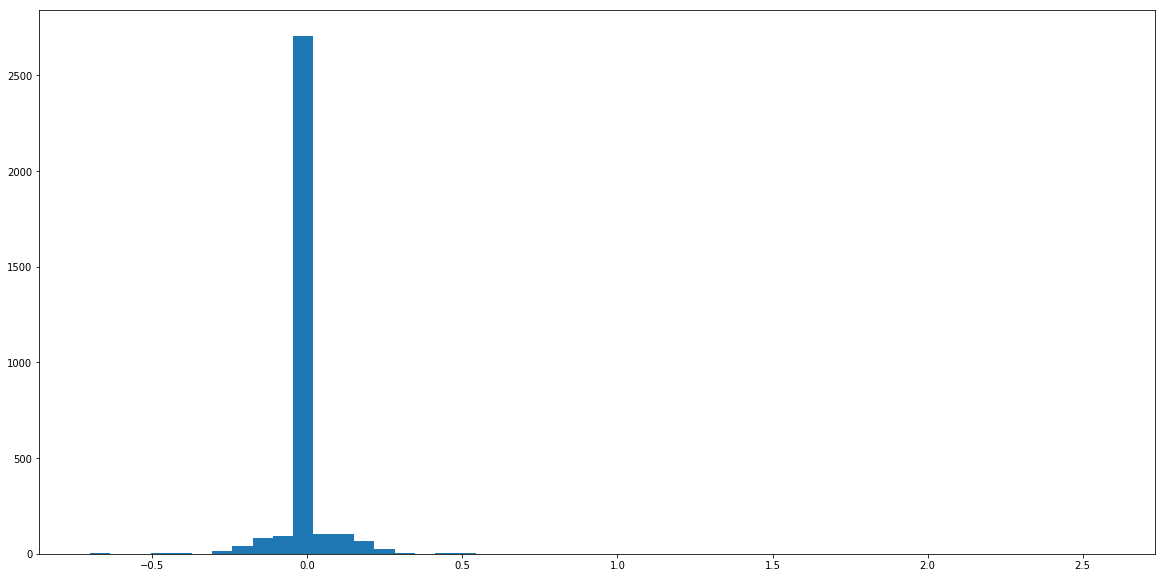

In [24]:
plt.figure(figsize=(20, 10))
plt.hist(tdf1[mask].length - tdf2[mask].length, bins=50)
plt.show()

In [25]:
def load_params(params_file):
    params = json.load(open(params_file))
    cameraMatrix1 = np.array(params['CameraParameters1']['IntrinsicMatrix']).transpose()
    cameraMatrix2 = np.array(params['CameraParameters2']['IntrinsicMatrix']).transpose()

    distCoeffs1 = params['CameraParameters1']['RadialDistortion'][0:2] + \
                   params['CameraParameters1']['TangentialDistortion'] + \
                   [params['CameraParameters1']['RadialDistortion'][2]]
    distCoeffs1 = np.array(distCoeffs1)

    distCoeffs2 = params['CameraParameters2']['RadialDistortion'][0:2] + \
                   params['CameraParameters2']['TangentialDistortion'] + \
                   [params['CameraParameters2']['RadialDistortion'][2]]
    distCoeffs2 = np.array(distCoeffs2)

    R = np.array(params['RotationOfCamera2']).transpose()
    T = np.array(params['TranslationOfCamera2']).transpose()

    imageSize = (4096, 3000)
    
    # perform rectification
    (R1, R2, P1, P2, Q, leftROI, rightROI) = cv2.stereoRectify(cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, imageSize, R, T, None, None, None, None, None, cv2.CALIB_ZERO_DISPARITY, 0)
    

    left_maps = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, imageSize, cv2.CV_16SC2)
    right_maps = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, imageSize, cv2.CV_16SC2)
    
    return left_maps, right_maps, cameraMatrix1, distCoeffs1, R1, P1

In [26]:
tdf1[mask].camera_metadata.iloc[0]

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


{'baseline': 0.101865756211485,
 'focalLength': 0.01382369154207327,
 'pixelCountWidth': 4096,
 'focalLengthPixel': 4006.8671136444264,
 'imageSensorWidth': 0.01412,
 'pixelCountHeight': 3000,
 'imageSensorHeight': 0.01035,
 'stereoParametersUrl': 'http://aquabyte-stereo-parameters.s3.eu-west-1.amazonaws.com/L40013180_R40029775/2020-01-14T00:00:00Z_L40013180_R40029775_stereo-parameters.json'}

In [27]:
matlab_params_f = '/root/data/alok/biomass_estimation/playground/2020-01-14T00_00_00Z_L40013180_R40029775_stereo-parameters.json'
circular_params_f = '/root/data/alok/biomass_estimation/playground/EstimatedStereoCamParams_L40013180_R40029775.json'

In [28]:
left_maps_m, right_maps_m, cameraMatrix1_m, distCoeffs1_m, R1_m, P1_m = load_params(matlab_params_f)
left_maps_c, right_maps_c, cameraMatrix1_c, distCoeffs1_c, R1_c, P1_c = load_params(circular_params_f)

In [29]:
left_maps_m[0].shape

(3000, 4096, 2)

In [40]:
cv2.undistortPoints(np.array([[left_maps_m[0][923, 294]]]).astype(float), cameraMatrix1_m, distCoeffs1_m, R=R1_m, P=P1_m)[0][0]

array([293.34640169, 922.27788938])

In [31]:
a, b = left_maps[0][923, 294] - right_maps[0][923, 294]

NameError: name 'left_maps' is not defined

In [136]:
tdf2.loc[mask, 'left_crop_metadata_m'] = tdf1[mask].left_crop_metadata
tdf2.loc[mask, 'right_crop_metadata_m'] = tdf1[mask].right_crop_metadata
new_anns = []
for idx, row in tdf2[mask].iterrows():
    captured_at = row.captured_at
    left_crop_metadata = row.left_crop_metadata_m
    right_crop_metadata = row.right_crop_metadata_m
    crop_x_coords = {'leftCrop': left_crop_metadata['x_coord'], 'rightCrop': right_crop_metadata['x_coord']}
    crop_y_coords = {'leftCrop': left_crop_metadata['y_coord'], 'rightCrop': right_crop_metadata['y_coord']}
    
    ann = json.loads(row.annotation)
    new_ann = {'leftCrop': [], 'rightCrop': []}
    for side in ['leftCrop', 'rightCrop']:
        for item in ann[side]:
            bp = item['keypointType']
            x, y = item['xFrame'], item['yFrame']
            maps = left_maps_c if side == 'leftCrop' else right_maps_c
            x_new, y_new = cv2.undistortPoints(np.array([[maps[0][y, x]]]).astype(float), 
                                cameraMatrix1_m, distCoeffs1_m, R=R1_m, P=P1_m)[0][0]
            new_ann[side].append({
                'keypointType': bp,
                'xFrame': x_new,
                'yFrame': y_new,
                'xCrop': x_new - crop_x_coords[side],
                'yCrop': y_new - crop_y_coords[side]
            })
    new_anns.append(new_ann)
    




/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [137]:
bp1, bp2 = 'UPPER_LIP', 'PELVIC_FIN'
tdf1.loc[mask, 'world_keypoints'] = tdf1[mask].annotation.apply(lambda x: pixel2world(x['leftCrop'], 
                                                  x['rightCrop'], cm1))

tdf1.loc[mask, 'length'] = tdf1[mask].world_keypoints.apply(lambda x: euclidean_distance(x[bp1], x[bp2]))

tdf2.loc[mask, 'world_keypoints'] = tdf2[mask].annotation.apply(lambda x: pixel2world(json.loads(x)['leftCrop'], 
                                                  json.loads(x)['rightCrop'], cm1))
tdf2.loc[mask, 'length'] = tdf2[mask].world_keypoints.apply(lambda x: euclidean_distance(x[bp1], x[bp2]))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [138]:
new_world_keypoints = [pixel2world(x['leftCrop'], x['rightCrop'], cm1) for x in new_anns]
tdf2.loc[mask, 'new_length'] = [euclidean_distance(x[bp1], x[bp2]) for x in new_world_keypoints]
tdf2.loc[mask, 'new_anns'] = new_anns
tdf2.loc[mask, 'new_world_keypoints'] = new_world_keypoints

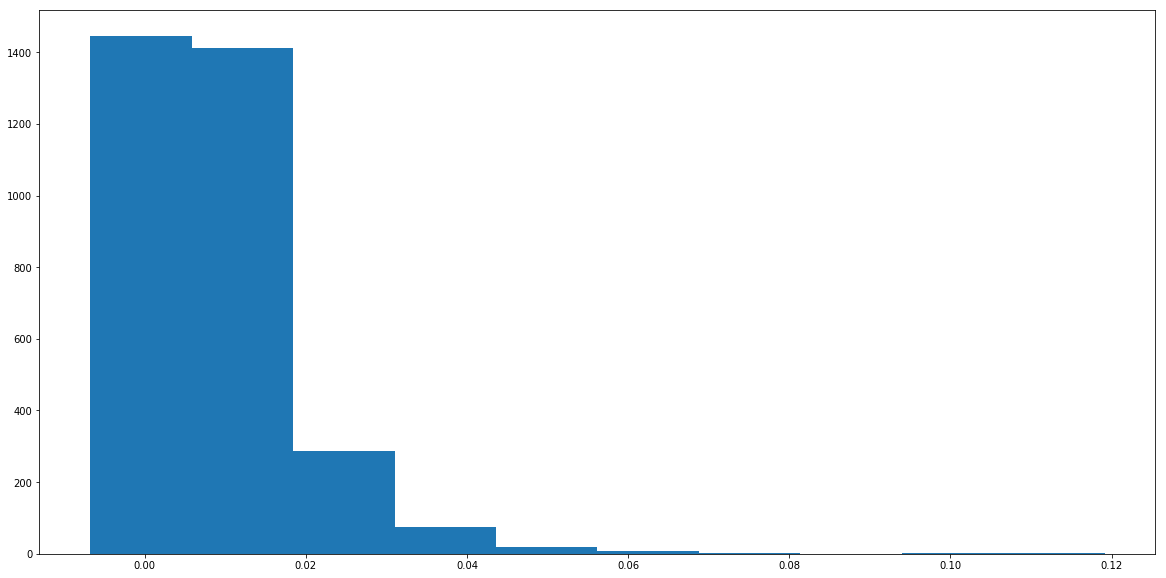

In [139]:
plt.figure(figsize=(20, 10))
plt.hist(tdf2[mask].length.values - tdf2[mask].new_length.values)
plt.show()

In [140]:
# get circular + matlab crop urls and annotations
ts = tdf2[mask & ((tdf2.length - tdf2.new_length).abs() > 0.02)].captured_at.iloc[0]
left_crop_url_c = tdf2[mask & ((tdf2.length - tdf2.new_length).abs() > 0.02)].left_crop_url.iloc[0]
right_crop_url_c = tdf2[mask & ((tdf2.length - tdf2.new_length).abs() > 0.02)].right_crop_url.iloc[0]
ann_c = json.loads(tdf2[mask & ((tdf2.length - tdf2.new_length).abs() > 0.02)].annotation.iloc[0])

left_crop_url_m = tdf1[mask & (tdf1.captured_at == ts)].left_crop_url.iloc[0]
right_crop_url_m = tdf1[mask & (tdf1.captured_at == ts)].right_crop_url.iloc[0]
ann_m = tdf2[mask & ((tdf2.length - tdf2.new_length).abs() > 0.02)].new_anns.iloc[0]



/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [146]:
def display_crops(left_crop_url, right_crop_url, ann, overlay_keypoints=True, show_labels=False):
    fig, axes = plt.subplots(2, 1, figsize=(20, 20))
    left_image_f, bucket, left_image_key = s3_access_utils.download_from_url(left_crop_url)
    right_image_f, _, right_image_key = s3_access_utils.download_from_url(right_crop_url)
    left_image = plt.imread(left_image_f)
    right_image = plt.imread(right_image_f)
    print(right_image.shape)
    axes[0].imshow(left_image)
    axes[1].imshow(right_image)
    
    left_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in ann['leftCrop']}
    right_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in ann['rightCrop']}
    if overlay_keypoints:
        for bp, kp in left_keypoints.items():
            axes[0].scatter([kp[0]], [kp[1]], color='red', s=1)
            if show_labels:
                axes[0].annotate(bp, (kp[0], kp[1]), color='red')
        for bp, kp in right_keypoints.items():
            axes[1].scatter([kp[0]], [kp[1]], color='red', s=1)
            if show_labels:
                axes[1].annotate(bp, (kp[0], kp[1]), color='red')
    plt.show()

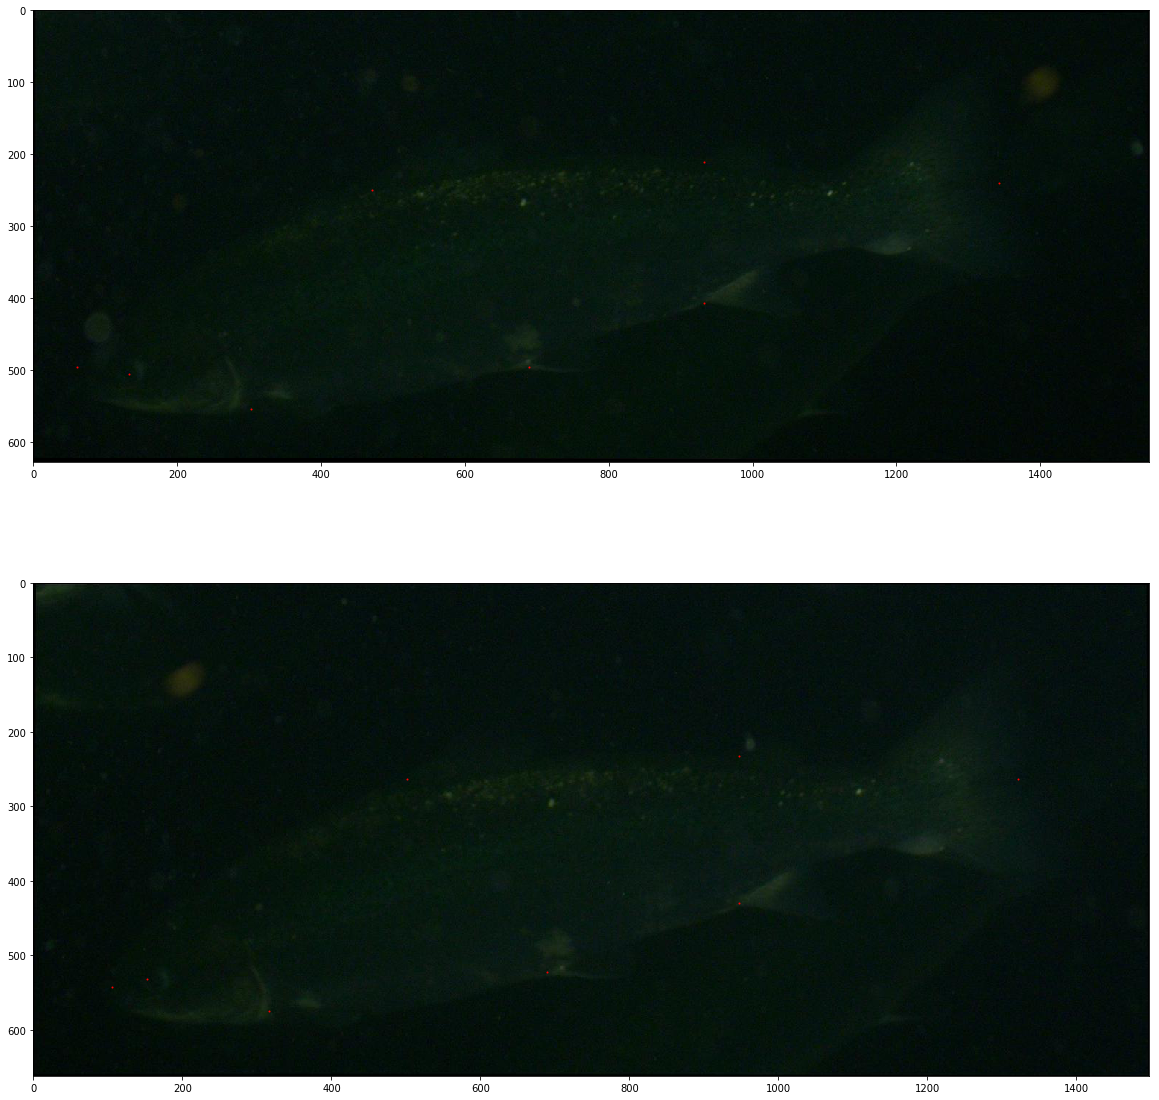

In [142]:
display_crops(left_crop_url_c, right_crop_url_c, ann_c)

(669, 1509, 3)


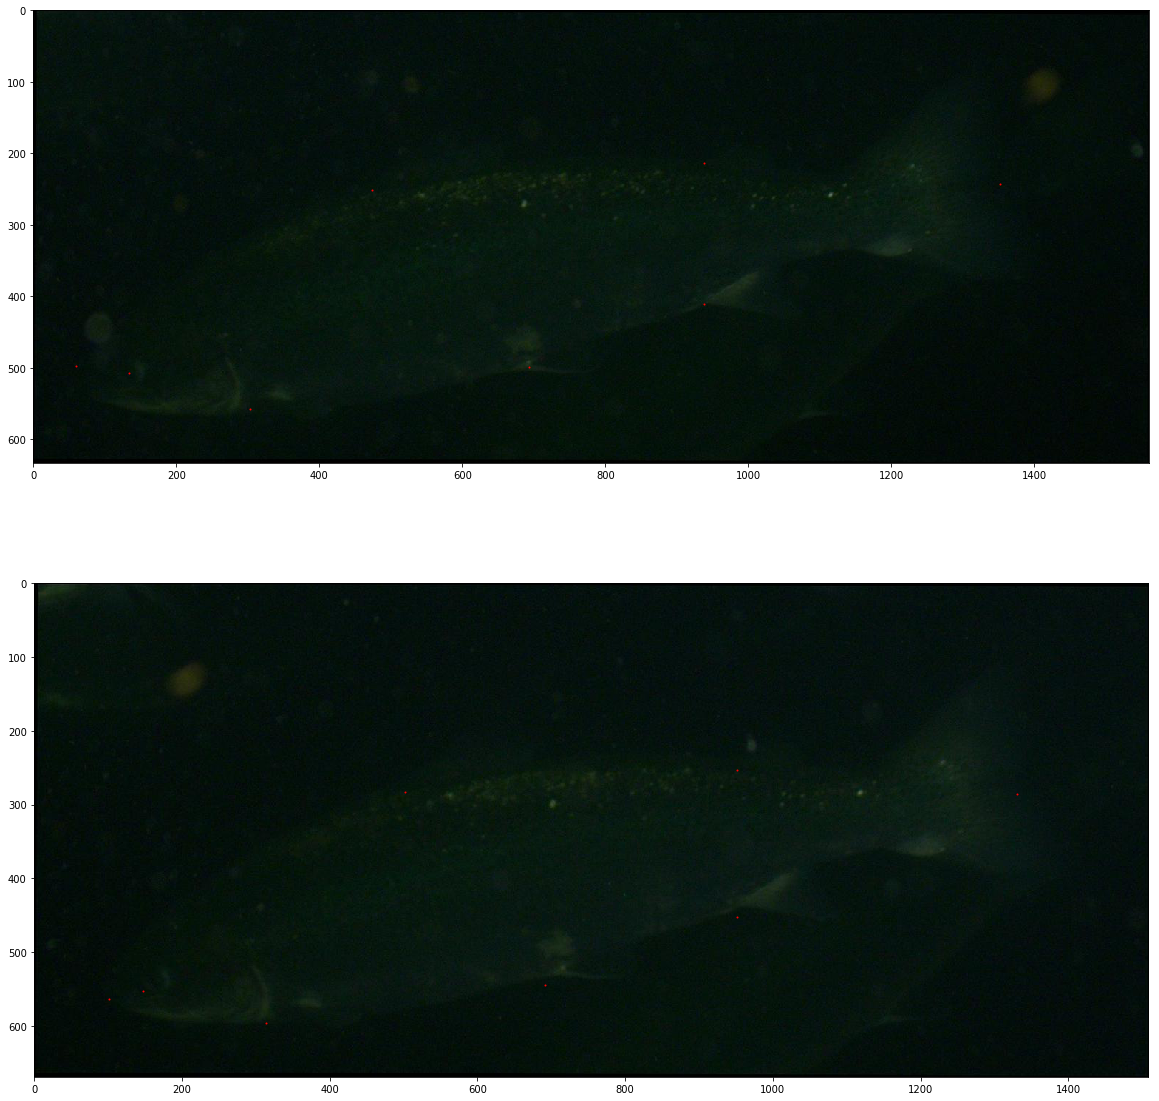

In [147]:
display_crops(left_crop_url_m, right_crop_url_m, ann_m)

In [151]:
tdf1.left_crop_metadata.iloc[0]

{'width': 2622,
 'height': 672,
 'x_coord': 199,
 'y_coord': 1520,
 'crop_area': 1674372,
 'quality_score': 0.34553790913847104,
 'mean_luminance': 31.023038488460152,
 'edge_detection_score': 0.34553790913847104,
 'mean_green_luminance': 36.169718900100904}

In [34]:
tdf1.left_crop_url.iloc[0]

'https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=staging/site-id=40/pen-id=61/date=2019-09-13/hour=00/at=2019-09-13T00:00:57.613770000Z/left_frame_crop_238_1520_2810_2171.jpg'

In [35]:
xFrame, yFrame = [1794 + 2718 - 2519, 297 + 1903 - 383]
print(xFrame, yFrame)

1993 1817


In [36]:
ptsTemp = np.array([], dtype='float32')
rtemp = ttemp = np.array([0,0,0], dtype='float32')
ptsOut = cv2.undistortPoints(np.array([yFrame, xFrame]).astype(float), cameraMatrix1_m, distCoeffs1_m)
ptsTemp = cv2.convertPointsToHomogeneous( ptsOut );
output = cv2.projectPoints( ptsTemp, rtemp, ttemp, cameraMatrix1, distCoeffs1_m, ptsOut );

NameError: name 'cameraMatrix1' is not defined

In [303]:
output

(array([[[1817., 1993.]]]),
 array([[ 2.50020631e+01,  4.01527519e+03, -4.90057395e+02,
          4.00302506e+03,  2.08554091e+00,  2.21316741e+02,
         -5.53110936e-02,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00, -4.00183302e+00, -7.22081843e-02,
         -5.42897475e+01,  9.68510853e+01, -1.30290841e-03],
        [-4.05938374e+03, -2.50028683e+01, -2.21631339e+02,
          2.08560807e+00,  3.99948546e+03, -4.89393295e+02,
          0.00000000e+00,  1.22304379e-01,  0.00000000e+00,
          1.00000000e+00,  8.84917353e+00,  1.59672518e-01,
          1.92351183e+02, -5.42914959e+01,  2.88109537e-03]]))

In [344]:
tdf1.iloc[0]

service_id                                                             2
pen_id                                                                61
annotation_state_id                                                    3
base_key               environment=staging/site-id=40/pen-id=61/date=...
url_key                https://aquabyte-crops.s3.eu-west-1.amazonaws....
right_crop_url         https://aquabyte-crops.s3.eu-west-1.amazonaws....
left_crop_metadata     {'width': 2622, 'height': 672, 'x_coord': 199,...
right_crop_metadata    {'width': 2416, 'height': 667, 'x_coord': 16, ...
camera_metadata        {'baseline': 0.101865756211485, 'focalLength':...
annotation             {'leftCrop': [{'xCrop': 2519, 'yCrop': 383, 'x...
captured_at                             2019-09-13 00:00:57.613770+00:00
ts_source_start                                2020-01-20 10:06:27+00:00
ts_source_end                                                       None
ts                                      2019-09-13 

In [345]:
tdf1.iloc[0].base_key

'environment=staging/site-id=40/pen-id=61/date=2019-09-13/hour=00/at=2019-09-13T00:00:57.613770000Z'

In [311]:
left_maps_m[0][yFrame, xFrame]

array([1995, 1805], dtype=int16)

In [312]:
tdf1.left_crop_metadata.iloc[0]

{'width': 2622,
 'height': 672,
 'x_coord': 199,
 'y_coord': 1520,
 'crop_area': 1674372,
 'quality_score': 0.34553790913847104,
 'mean_luminance': 31.023038488460152,
 'edge_detection_score': 0.34553790913847104,
 'mean_green_luminance': 36.169718900100904}

In [38]:
left_maps_m[0][xFrame, yFrame]

array([1822, 1979], dtype=int16)

In [290]:
cv2.undistortPoints(np.array([[1981, 1806]]).astype(float), cameraMatrix1_m, distCoeffs1_m, R=R1_m, P=P1_m)[0][0]



array([1978.1940372 , 1817.42770231])

(2353, 363)

In [277]:
1743 + 238, 286+1520

(1981, 1806)

In [295]:
left_maps_m[0][1806, 1981]

array([1983, 1794], dtype=int16)

In [292]:
left_maps_m[0][1981, 1806]

array([1811, 1967], dtype=int16)

In [323]:
s3_access_utils = S3AccessUtils('/root/data')
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

query = """
    SELECT * FROM
    prod.crop_annotation cas
    INNER JOIN prod.annotation_state pas on pas.id=cas.annotation_state_id
    WHERE cas.service_id = (SELECT ID FROM prod.service where name='BATI')
    AND cas.annotation is not null
    AND cas.pen_id=88
    AND cas.captured_at between '2020-02-20' and '2020-02-21';
"""

df = rds_access_utils.extract_from_database(query)
aws_credentials = json.load(open(os.environ['AWS_CREDENTIALS']))
akpd = AKPD(aws_credentials)

to_tensor_transform = ToTensor()

# initialize data transforms so that we can run inference with biomass neural network
normalize_centered_2D_transform_biomass = NormalizeCentered2D()
normalized_stability_transform = NormalizedStabilityTransform()

# load neural network weights
biomass_network = torch.load('/root/data/alok/biomass_estimation/results/neural_network/2019-11-08T00:13:09/nn_epoch_798.pb')
akpd_scorer_network = load_model('/root/data/alok/biomass_estimation/playground/akpd_scorer_model_TF.h5') # make this better

In [326]:
df.left_crop_url.iloc[0]

'https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=56/pen-id=88/date=2020-02-20/hour=00/at=2020-02-20T00:00:21.387373000Z/left_frame_crop_1604_2036_3676_3000.jpg'

In [327]:
df.camera_metadata.iloc[0]

{'baseline': 0.10149353564369845,
 'focalLength': 0.013799853253882617,
 'pixelCountWidth': 4096,
 'focalLengthPixel': 3999.957464893512,
 'imageSensorWidth': 0.01412,
 'pixelCountHeight': 3000,
 'imageSensorHeight': 0.01035,
 'stereoParametersUrl': 'http://aquabyte-stereo-parameters.s3.eu-west-1.amazonaws.com/L40039154_R40012648/2020-02-19T03:42:04.748042000Z_L40039154_R40012648_stereo-parameters.json'}

In [330]:
df.left_crop_metadata.iloc[0]

{'width': 2103,
 'height': 975,
 'x_coord': 1577,
 'y_coord': 2024,
 'category': {'id': 1,
  'name': 'salmon',
  'model_id': 2,
  'model_class': 0,
  'supercategory': 'fish',
  'objectConfidence': 0.9391918,
  'categoryConfidence': 0.99999774},
 'crop_area': 1997408,
 'quality_score': 0.2387108692865954,
 'mean_luminance': 21.966341378426442,
 'edge_detection_score': 0.2387108692865954,
 'mean_green_luminance': 31.08154656081172,
 'object_detection_model': {'id': 2,
  'name': 'object-detection-bati',
  'version': 'a5e636b781a2cf33b706517aea94fde0'}}

In [328]:
matlab_params_f = '/root/data/alok/biomass_estimation/playground/2020-02-19T03_42_04.748042000Z_L40039154_R40012648_stereo-parameters.json'
left_maps_m, right_maps_m, cameraMatrix1_m, distCoeffs1_m, R1_m, P1_m = load_params(matlab_params_f)


In [331]:
xFrame = 1217 + 1577
yFrame = 2024 + 781

In [335]:
left_maps_m[0][yFrame, xFrame]

array([2803, 2799], dtype=int16)

In [336]:
1200 + 1604, 764 + 2036

(2804, 2800)